In [25]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools
import matplotlib.patches as mpatches
from scipy.signal import find_peaks

In [26]:
def find_local_extrema(x, f_x, window, p, extreme):
    ## Find local minima/maxima in f(x)

    # Apply a simple moving average to smooth the curve
    smoothed_f_x = np.convolve(f_x, np.ones(window)/window, mode='valid')
        
    # Adjust x accordingly
    diff = len(f_x) - len(smoothed_f_x)
    smoothed_x = x[int(diff/2) : int(diff/2)+len(smoothed_f_x)]

    # subset every N-th
    N = 1
    sub_smoothed_f_x = smoothed_f_x[0::N]
    sub_smoothed_x = smoothed_x[0::N].reset_index()['start']

    # Find peaks in the negative gradient, which correspond to local minima
    if extreme == 'min':
        minima_indices, _ = find_peaks(-sub_smoothed_f_x, prominence=p)
    elif extreme == 'max':    
        minima_indices, _ = find_peaks(sub_smoothed_f_x, prominence=p)
    else:
        print('you requested invalid extremum! Can be min or max')

    # Extract x values corresponding to the minima
#     minima_x = smoothed_x[minima_indices]
    return sub_smoothed_x, sub_smoothed_f_x, minima_indices

In [27]:
# Load ALL data
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'anoImb', 'taeGut', 'poeAcu', 'indInd', 'picPub', 
       'molAte', 'agePho', 'hetAtr', 'nipNip', 'xxxXXX']
bps = ['vidMac', 'vidCha', 'anoImb', 'indInd', 'molAte', 'hetAtr']

all_DFs = {}
i = 0
for db in dbs:
    file_name = 'OmegaPlus_{}/intersect.LR.pi.depth.omega.bed'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_DFs[db] = df


In [28]:
# Compute overall stats
dfs_omega = []

for db in dbs:
    df = all_DFs[db]
    temp_df = df.groupby('scaffold', as_index=False).mean()[['scaffold', 'omega', 'PI', 'LR']]
    temp_df['db'] = [db] * temp_df.shape[0]
    dfs_omega.append(temp_df)
    
all_omega_DF =  pd.concat(dfs_omega, ignore_index = True)

## label brood parasites
all_omega_DF['bp'] = ['bp' if i in bps else 'out' for i in all_omega_DF['db']]
all_omega_DF.head()

,scaffold,omega,PI,LR,db,bp
0,CM044060.1,1.574795,0.002445,2.095912,vidMac,bp
1,CM044061.1,1.509343,0.002610,5.333208,vidMac,bp
2,CM044062.1,1.572985,0.002399,2.627930,vidMac,bp
3,CM044063.1,1.453966,0.002767,4.701994,vidMac,bp
4,CM044064.1,1.513124,0.002665,3.574328,vidMac,bp


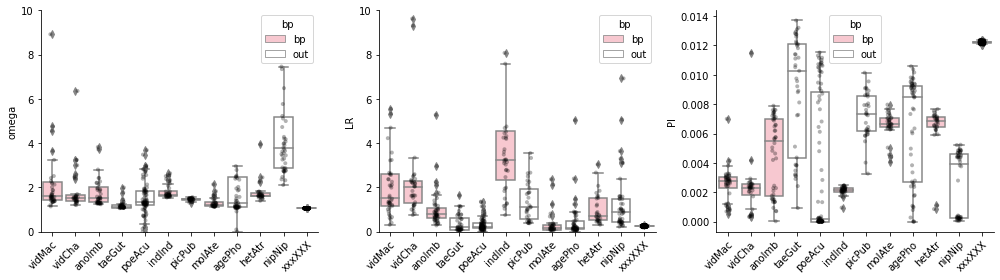

In [30]:
# Plot omega by chr by db
values = ['omega', 'LR', 'PI']
colors = ['pink', 'white']
sns.set_palette(colors)

fig, axes = plt.subplots(1, 3, figsize = (14, 4))

for i in range(3):
    axi = axes[i]
    v = values[i]

    sns.boxplot(ax=axi, data=all_omega_DF, x='db', y=v,  hue='bp', dodge=False)
    sns.stripplot(ax=axi, data=all_omega_DF, x='db', y=v, color='black', alpha=0.3, s=4)
    
    axi.set_xlabel('')
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    if v == 'omega':
        axi.set_ylim(0, 10)
    elif v == 'LR':
        axi.set_ylim(0, 10)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'full_axes.omega_LR_PI.by_db.summary_stats.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

1.089973


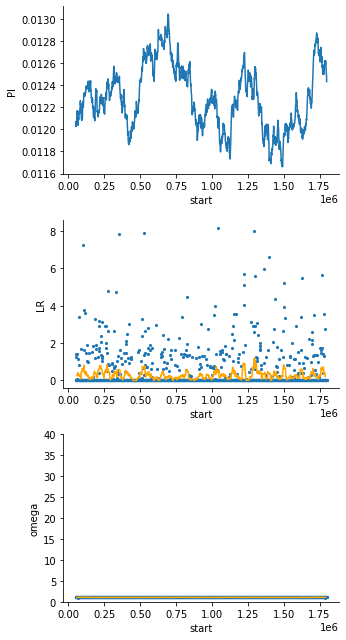

In [34]:
# OmegaPlus LD analysis
sns.set_palette('tab10')

## Plot 4Mb regions of a chr
df_full = all_DFs['xxxXXX']

C = 'chr36'
n = 0
df = df_full[(df_full['scaffold'] == C) & (df_full['start'] > n*10**6) & (df_full['start'] < (n+1.8)*10**6)]


## Define the window size for the moving average
window = 20
p_pi = 0.0001
p_lr = np.average(df['LR']) + 10
p_o = np.percentile(df['omega'], 90)
# p_o = np.average(df['omega'])
print(p_o)


fig, axes = plt.subplots(3, 1, figsize = (5, 3*3))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

## PI
x = df['start']
f_x = df['PI']
smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_pi, 'min')
pi_peaks = smoothed_x[minima_indices]

sns.lineplot(ax=ax1, data=df, x='start', y='PI')
# sns.lineplot(ax=ax1, x=smoothed_x, y=smoothed_f_x)
# sns.scatterplot(ax=ax1, x=smoothed_x[minima_indices], y=smoothed_f_x[minima_indices], color='red', s=50)


## SF2
x = df['start']
f_x = df['LR']
smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_lr, 'max')
lr_peaks = smoothed_x[minima_indices]

sns.scatterplot(ax=ax2, data=df, x='start', y='LR', linewidth=0, s=10)
sns.lineplot(ax=ax2, x=smoothed_x, y=smoothed_f_x, color='orange')
sns.scatterplot(ax=ax2, x=smoothed_x[minima_indices], y=smoothed_f_x[minima_indices], color='red', s=40)


## Extend region of PI peaks +- delta (50k in total)
delta = 25000
pi_peaks_region = []
for el in pi_peaks:
    pi_peaks_region.extend([i for i in range(el - delta, el + delta)])

## Overlap peaks
peaks_overlap = [i for i in lr_peaks if i in pi_peaks_region]
sns.scatterplot(ax=ax2, x=peaks_overlap, y=100, color='red', marker="+", s=200)


 
## Omega
x = df['start']
f_x = df['omega']
smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_o, 'max')
op_peaks = smoothed_x[minima_indices]

sns.scatterplot(ax=ax3, data=df, x='start', y='omega', linewidth=0, s=10)
sns.lineplot(ax=ax3, x=smoothed_x, y=smoothed_f_x, color='orange')
sns.scatterplot(ax=ax3, x=smoothed_x[minima_indices], y=smoothed_f_x[minima_indices], color='red', s=40)
ax3.set_ylim(0, 40)

## Overlap peaks
peaks_overlap = [i for i in op_peaks if i in pi_peaks_region]
sns.scatterplot(ax=ax3, x=peaks_overlap, y=10, color='red', marker="+", s=200)


sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [35]:
### Now don't plot anything but quantify! and store peak coordinates in a dictionary
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# dbs = ['vidMac', 'vidCha', 'anoImb', 'taeGut', 'poeAcu', 'indInd', 'picPub', 'molAte', 'agePho']
# dbs = ['hetAtr']
dbs = ['xxxXXX']
peaks_overlap_by_db = {}

## hardcoded parameters
delta = 25000 # (50k region in total)
window = 20
p_pi = 0.0001
depth_cutoff = 100

for db in dbs:
    ## Read LR, PI, depth tables
    file_name = 'OmegaPlus_{}/intersect.LR.pi.depth.omega.bed'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df_full = pd.read_csv(file_data, sep='\t')
    
    peaks_overlap_SF2 = {}
    peaks_overlap_OP = {}
    all_chr = set(df_full['scaffold'])
    
    for chrom in all_chr:
        df = df_full[df_full['scaffold'] == chrom]

        ## Define the window size for the moving average
        p_lr = np.average(df['LR']) + 10
#         p_o = np.percentile(df['omega'], 90)
        p_o = np.average(df['omega'])

        ## PI
        x = df['start']
        f_x = df['PI']
        smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_pi, 'min')
        pi_peaks = smoothed_x[minima_indices]

        ## SF2. exclude chrom outliers!
        mean_chr_value = all_omega_DF[(all_omega_DF['db'] == db) & (all_omega_DF['scaffold'] == chrom)]['LR']
        if (mean_chr_value < 10).any():
            x = df['start']
            f_x = df['LR']
            smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_lr, 'max')
            lr_peaks = smoothed_x[minima_indices]
        else:
            lr_peaks = []

        ## OmegaPlus. exclude chrom outliers!
        mean_chr_value = all_omega_DF[(all_omega_DF['db'] == db) & (all_omega_DF['scaffold'] == chrom)]['omega']
        if (mean_chr_value < 10).any():
            x = df['start']
            f_x = df['omega']
            smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_o, 'max')
            op_peaks = smoothed_x[minima_indices]
        else:
            op_peaks = []
        
        ## Extend region of PI peaks +- delta
        pi_peaks_region = []
        for el in pi_peaks:
            pi_peaks_region.extend([i for i in range(el - delta, el + delta)])

        ## Overlap peaks. Add depth filter
        peaks_overlap_SF2[chrom] = [i for i in lr_peaks if (i in pi_peaks_region and df[df['start']==i]['depth'].values[0]>=depth_cutoff)]
        peaks_overlap_OP[chrom]  = [i for i in op_peaks if (i in pi_peaks_region and df[df['start']==i]['depth'].values[0]>=depth_cutoff)]
        
        # Foreget about PI, just LR peaks with depth filter
        peaks_overlap_SF2[chrom] = [i for i in lr_peaks if (df[df['start']==i]['depth'].values[0]>=depth_cutoff)]
        peaks_overlap_OP[chrom]  = [i for i in op_peaks if (df[df['start']==i]['depth'].values[0]>=depth_cutoff)]
        
        print(chrom, len(peaks_overlap_SF2[chrom]))
        print(chrom, len(peaks_overlap_OP[chrom]))
        
    peaks_overlap_by_db[db] = (peaks_overlap_SF2, peaks_overlap_OP)

chr481 0
chr481 0
chr310 0
chr310 0
chr306 0
chr306 0
chr282 0
chr282 0
chr349 0
chr349 0
chr304 0
chr304 0
chr315 0
chr315 0
chr157 0
chr157 0
chr65 0
chr65 0
chr444 0
chr444 0
chr69 0
chr69 0
chr191 0
chr191 0
chr218 0
chr218 0
chr228 0
chr228 0
chr471 0
chr471 0
chr77 0
chr77 0
chr26 0
chr26 0
chr59 0
chr59 0
chr110 0
chr110 0
chr290 0
chr290 0
chr494 0
chr494 0
chr420 0
chr420 0
chr20 0
chr20 0
chr496 0
chr496 0
chr154 0
chr154 0
chr222 0
chr222 0
chr399 0
chr399 0
chr457 0
chr457 0
chr341 0
chr341 0
chr230 0
chr230 0
chr240 0
chr240 0
chr14 0
chr14 0
chr122 0
chr122 0
chr379 0
chr379 0
chr274 0
chr274 0
chr393 0
chr393 0
chr150 0
chr150 0
chr101 0
chr101 0
chr54 0
chr54 0
chr490 0
chr490 0
chr79 0
chr79 0
chr322 0
chr322 0
chr128 0
chr128 0
chr499 0
chr499 0
chr189 0
chr189 0
chr482 0
chr482 0
chr225 0
chr225 0
chr192 0
chr192 0
chr43 0
chr43 0
chr497 0
chr497 0
chr187 0
chr187 0
chr431 0
chr431 0
chr336 0
chr336 0
chr434 0
chr434 0
chr200 0
chr200 0
chr437 0
chr437 0
chr38 0
chr3

chr487 0
chr487 0
chr488 0
chr488 0
chr137 0
chr137 0
chr63 0
chr63 0
chr121 0
chr121 0
chr263 0
chr263 0
chr316 0
chr316 0
chr478 0
chr478 0
chr376 0
chr376 0
chr216 0
chr216 0
chr500 0
chr500 0
chr498 0
chr498 0
chr249 0
chr249 0
chr11 0
chr11 0
chr278 0
chr278 0
chr53 0
chr53 0
chr194 0
chr194 0
chr453 0
chr453 0
chr196 0
chr196 0
chr267 0
chr267 0
chr329 0
chr329 0
chr305 0
chr305 0
chr212 0
chr212 0
chr419 0
chr419 0
chr445 0
chr445 0
chr331 0
chr331 0
chr12 0
chr12 0
chr301 0
chr301 0
chr33 0
chr33 0
chr23 0
chr23 0
chr276 0
chr276 0
chr217 0
chr217 0
chr83 0
chr83 0


In [37]:
## Report the number of LR peaks alone
for db in dbs:
    all_peaks = list(itertools.chain(*[l for l in peaks_overlap_by_db[db][0].values() if l]))
    print('{} {}'.format(db, len(all_peaks)))

xxxXXX 0


In [13]:
### Write OmegaPlus peaks +- flanks to a file
# delta = 100000
delta = 1

for db in dbs:
    out_file = 'OmegaPlus_{}/omegaPlus_peaks_low_PI_depth100.{}bp.bed'.format(db, delta*2)
    peaks_overlap = peaks_overlap_by_db[db][1]
    
    with open(out_file, 'w') as ouf:
        for chrom in peaks_overlap:
            for peak in peaks_overlap[chrom]:
                bed_line = chrom + "\t" + str(peak - delta) + "\t" + str(peak + delta) + '\n'
                ouf.write(bed_line)

posx and posy should be finite values
posx and posy should be finite values
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/adjustText/__init__.py:31: RuntimeWarning: invalid value encountered in less
  x_in = np.logical_and(x>x1, x<x2)
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/adjustText/__init__.py:31: RuntimeWarning: invalid value encountered in greater
  x_in = np.logical_and(x>x1, x<x2)
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/adjustText/__init__.py:32: RuntimeWarning: invalid value encountered in less
  y_in = np.logical_and(y>y1, y<y2)
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/adjustText/__init__.py:32: RuntimeWarning: invalid value encountered in greater
  y_in = np.logical_and(y>y1, y<y2)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


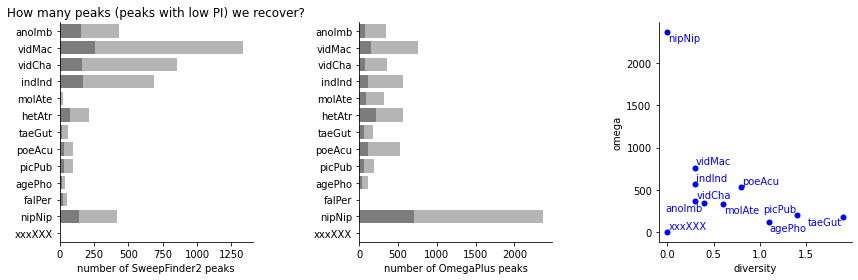

In [17]:
## Plot Omega, LR peaks
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'all_bp.peaks_genes_number.SF2.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')


fig, axes = plt.subplots(1, 3, figsize = (12, 4))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]



ax1.set_title('How many peaks (peaks with low PI) we recover?')

## Plot # of peaks/genes SF2
blue = '#4287f5'
grey1 = '#b5b5b5'
grey2 = '#7c7c7d'
sns.barplot(ax=ax1, data=df, y='db', x='LR', color=grey1)
sns.barplot(ax=ax1, data=df, y='db', x='LR_sweeps', color=grey2)
# sns.barplot(ax=ax1, data=df, y='db', x='genes', color=blue)
ax1.set_ylabel('')
ax1.set_xlabel('number of SweepFinder2 peaks')

sns.barplot(ax=ax2, data=df, y='db', x='omega', color=grey1)
sns.barplot(ax=ax2, data=df, y='db', x='omega_sweeps', color=grey2)
ax2.set_ylabel('')
ax2.set_xlabel('number of OmegaPlus peaks')


## Plot correlation: # peaks VS Theta
sns.scatterplot(ax=ax3, data=df, x='diversity', y='omega', color='blue', linewidth=0)
# ax3.set_xlim(-0.1, 2)

labels = []
for x, y, db in zip(df['diversity'], df['omega'], df['db']):
    labels.append(ax3.text(x=x, y=y, s=db, color='blue', size=10))
adjust_text(labels, ax=ax3)

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'all_bp.LR_omega_peaks_genes_number.SF2.theta.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

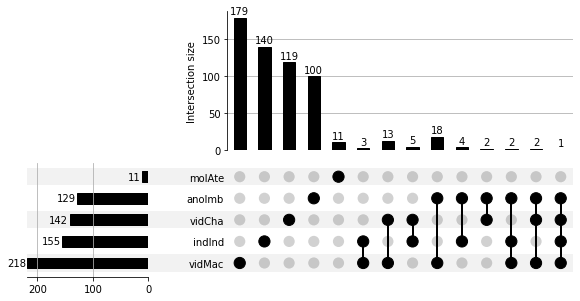

In [23]:
from upsetplot import plot
plot_size = 5

## Dir for the output
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'

dbs = ['vidMac', 'vidCha', 'anoImb', 'indInd', 'molAte']
sets_by_db = {}

for db in dbs:
    file_name = 'PopGen_{}/hg38.genes.SF2_peaks_low_PI_depth100.1Mb_domain.lst'.format(db)
    with open(dir_path + file_name, 'r') as inf:
        genes = inf.read().rstrip('\n').split('\n')
    sets_by_db[db] = set(genes)

set1 = sets_by_db['vidMac']
set2 = sets_by_db['vidCha']
set3 = sets_by_db['anoImb']
set4 = sets_by_db['indInd']
set5 = sets_by_db['molAte']

all_elems = set1.union(set2).union(set3).union(set4).union(set5)
df = pd.DataFrame([[e in set1, 
                    e in set2, 
                    e in set3,
                    e in set4,
                    e in set5] for e in all_elems], columns = dbs)
dfi = df.groupby(dbs).size()

fig = plt.figure(figsize=(10, 5))
plot(dfi, fig=fig, orientation='horizontal', totals_plot_elements=plot_size, show_counts=True)    
# plt.savefig("{}SweepFinder2.genes_all.upsetplot.pdf".format(dir_path))

In [28]:
set3.intersection(set4)

{'ADGRB3', 'DYSF', 'FLRT2', 'IMMP2L', 'PCDH10', 'PI15', 'SLITRK5'}